In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import importlib
import scripts.preprocessing as preprocessing
importlib.reload(preprocessing)
import torch
import torch.nn as nn
import torchvision
import torchsummary
import torch.optim as optim
import scripts.models as models
import os
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import mlflow
import mlflow.pytorch
import torch

importlib.reload(models)

<module 'scripts.models' from '/home/ronin/Dev/notebooks/machinelearningformodeling/supervised/project/scripts/models.py'>

In [9]:
model = models.ColorizationSqueezeNet()

In [10]:
torchsummary.summary(model, (1, 224, 224));


Layer (type:depth-idx)                   Output Shape              Param #


├─Sequential: 1-1                        [-1, 512, 14, 14]         --

|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        640

|    └─ReLU: 2-2                         [-1, 64, 112, 112]        --

|    └─MaxPool2d: 2-3                    [-1, 64, 56, 56]          --

|    └─Fire: 2-4                         [-1, 128, 56, 56]         --

|    |    └─Conv2d: 3-1                  [-1, 16, 56, 56]          1,040

|    |    └─ReLU: 3-2                    [-1, 16, 56, 56]          --

|    |    └─Conv2d: 3-3                  [-1, 64, 56, 56]          1,088

|    |    └─ReLU: 3-4                    [-1, 64, 56, 56]          --

|    |    └─Conv2d: 3-5                  [-1, 64, 56, 56]          9,280

|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --

|    └─Fire: 2-5                         [-1, 128, 56, 56]         --

|    |    └─Conv2d: 3-7                  [-1, 16, 56, 56]   

In [11]:
class ImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        grayscale_image = transforms.functional.rgb_to_grayscale(image, num_output_channels=1)
        
        return grayscale_image, image

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = ImageDataset(image_folder='SSL/images', transform=transform)

torch.manual_seed(42)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [17]:
# Initialize model, loss function, and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [18]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=20, run_name = None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    with mlflow.start_run(run_name=run_name):
        mlflow.log_param("num_epochs", num_epochs)
        mlflow.log_param("learning_rate", optimizer.param_groups[0]['lr'])
        mlflow.log_param("batch_size", train_dataloader.batch_size)
        
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0

            # Use tqdm for the progress bar
            progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

            for grayscale, color in progress_bar:
                grayscale = grayscale.to(device)
                color = color.to(device)

                optimizer.zero_grad()
                outputs = model(grayscale)
                loss = criterion(outputs, color)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * grayscale.size(0)

                # Update progress bar with the current loss
                progress_bar.set_postfix(loss=loss.item())

            epoch_loss = running_loss / len(train_dataloader.dataset)
            print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")
            mlflow.log_metric("train_loss", epoch_loss, step=epoch)

            # Validation phase
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for grayscale, color in val_dataloader:
                    grayscale = grayscale.to(device)
                    color = color.to(device)

                    outputs = model(grayscale)
                    loss = criterion(outputs, color)

                    val_loss += loss.item() * grayscale.size(0)

            val_loss /= len(val_dataloader.dataset)
            print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")
            mlflow.log_metric("val_loss", val_loss, step=epoch)

        # Log the model at the end of the run
        mlflow.pytorch.log_model(model, "colorization_model")

In [20]:
# Start training
train(model = model, 
      train_dataloader = train_dataloader, 
      val_dataloader= test_dataloader, 
      criterion = criterion, 
      optimizer = optimizer, 
      num_epochs=10, 
      run_name="colorization_model_v2_with_validation")

Epoch 1/10: 100%|██████████| 3219/3219 [41:53<00:00,  1.28it/s, loss=0.0244] 


Epoch 1/10, Training Loss: 0.0158

Epoch 1/10, Validation Loss: 0.0217


Epoch 2/10: 100%|██████████| 3219/3219 [43:03<00:00,  1.25it/s, loss=0.0106] 


Epoch 2/10, Training Loss: 0.0129

Epoch 2/10, Validation Loss: 0.0126


Epoch 3/10: 100%|██████████| 3219/3219 [41:34<00:00,  1.29it/s, loss=0.0102] 


Epoch 3/10, Training Loss: 0.0121

Epoch 3/10, Validation Loss: 0.0121


Epoch 4/10: 100%|██████████| 3219/3219 [41:34<00:00,  1.29it/s, loss=0.00791]


Epoch 4/10, Training Loss: 0.0117

Epoch 4/10, Validation Loss: 0.0117


Epoch 5/10: 100%|██████████| 3219/3219 [41:36<00:00,  1.29it/s, loss=0.00977]


Epoch 5/10, Training Loss: 0.0113

Epoch 5/10, Validation Loss: 0.0113


Epoch 6/10: 100%|██████████| 3219/3219 [41:36<00:00,  1.29it/s, loss=0.00779]


Epoch 6/10, Training Loss: 0.0111

Epoch 6/10, Validation Loss: 0.0110


Epoch 7/10: 100%|██████████| 3219/3219 [42:38<00:00,  1.26it/s, loss=0.014]  


Epoch 7/10, Training Loss: 0.0109

Epoch 7/10, Validation Loss: 0.0120


Epoch 8/10: 100%|██████████| 3219/3219 [43:38<00:00,  1.23it/s, loss=0.00854]


Epoch 8/10, Training Loss: 0.0107

Epoch 8/10, Validation Loss: 0.0107


Epoch 9/10: 100%|██████████| 3219/3219 [43:50<00:00,  1.22it/s, loss=0.00708]


Epoch 9/10, Training Loss: 0.0105

Epoch 9/10, Validation Loss: 0.0106


Epoch 10/10: 100%|██████████| 3219/3219 [44:06<00:00,  1.22it/s, loss=0.0158] 


Epoch 10/10, Training Loss: 0.0104

Epoch 10/10, Validation Loss: 0.0109


In [21]:

# save model to disk
torch.save(model.state_dict(), 'modelSSL_10e.pth')

In [34]:
# load mdel from disk
model = models.ColorizationSqueezeNet()
model.load_state_dict(torch.load('modelSSL.pth'))

<All keys matched successfully>

In [35]:
model.features[0]

Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

In [22]:
# load netFromSSL from disk
# Load the original state dictionary
state_dict = torch.load('modelSSL_10e.pth')


In [23]:
# Modify the first layer's weights to handle three channels
original_weights = state_dict['features.0.weight']  # Shape: [64, 1, 3, 3]

# Create a new weight tensor with three channels
new_weights = torch.zeros((original_weights.size(0), 
                           3, 
                           original_weights.size(2), 
                           original_weights.size(3)))

# Copy the original weights to each of the three channels
new_weights[:, 0:1, :, :] = original_weights
new_weights[:, 1:2, :, :] = original_weights
new_weights[:, 2:3, :, :] = original_weights

# Replace the weights in the state dictionary
state_dict['features.0.weight'] = new_weights

In [24]:
netFromSSL = models.SqueezeNet()

# Extract the `features` part of the state dictionary and remove the "features." prefix
features_state_dict = {k.replace('features.', ''): v for k, v in state_dict.items() if k.startswith('features.')}

# Create the SqueezeNet model with three input channels
netFromSSL = models.SqueezeNet()

# Load the `features` part of the state dictionary into the new model
netFromSSL.features.load_state_dict(features_state_dict)



<All keys matched successfully>

In [25]:
torch.save(netFromSSL.state_dict(), 'netFromSSL_10e.pth')

In [80]:
import torch
import matplotlib.pyplot as plt
import random

# Assuming these are the normalization parameters used during preprocessing
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

def denormalize(tensor, mean, std):
    """
    Denormalizes a tensor using the provided mean and standard deviation.
    """
    tensor = tensor.clone()  # Create a copy to avoid modifying the original tensor
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def show_random_test_image(model, test_dataset, denormalization=False):
    """
    Displays a random image from the test dataset along with its grayscale, original colored,
    and reconstructed versions from the model.

    Parameters:
    - model: The trained model to use for reconstructing the image.
    - test_dataset: The dataset containing the test images.
    - denormalization: Boolean indicating whether to apply denormalization to the images.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    idx = random.randint(0, len(test_dataset) - 1)
    grayscale_image, color_image = test_dataset[idx]
    
    # Add batch dimension
    grayscale_image = grayscale_image.unsqueeze(0).to(device)
    color_image = color_image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        reconstructed_image = model(grayscale_image)
    
    # Denormalize images if required
    if denormalization:
        grayscale_image = denormalize(grayscale_image.squeeze(0).cpu(), mean, std)
        color_image = denormalize(color_image.squeeze(0).cpu(), mean, std)
        reconstructed_image = denormalize(reconstructed_image.squeeze(0).cpu(), mean, std)
    else:
        grayscale_image = grayscale_image.squeeze(0).cpu()
        color_image = color_image.squeeze(0).cpu()
        reconstructed_image = reconstructed_image.squeeze(0).cpu()
    
    # Convert to numpy for visualization
    grayscale_image = grayscale_image.numpy().transpose(1, 2, 0)
    color_image = color_image.numpy().transpose(1, 2, 0)
    reconstructed_image = reconstructed_image.numpy().transpose(1, 2, 0)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(grayscale_image.squeeze(), cmap='gray')
    axes[0].set_title('Grayscale image')
    axes[0].axis('off')
    
    axes[1].imshow(color_image)
    axes[1].set_title('Original colored image (SSL label)')
    axes[1].axis('off')
    
    axes[2].imshow(reconstructed_image)
    axes[2].set_title('Reconstructed image')
    axes[2].axis('off')
    
    plt.show()

# Example call to the function
# Ensure that `model` and `test_dataset` are defined before calling this function.
# show_random_test_image(model, test_dataset, denormalization=True)


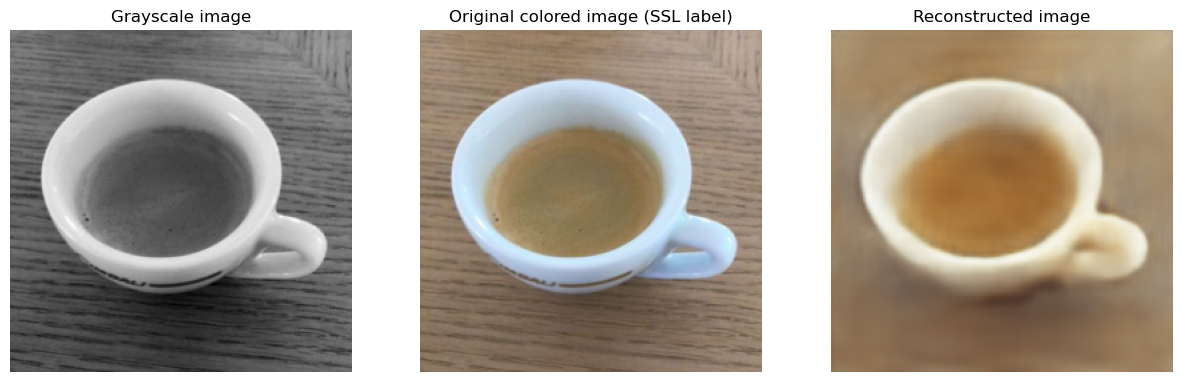

In [175]:
show_random_test_image(model, test_dataset, denormalization=False)

In [51]:

grayscale_image, color_image = test_dataset[0]

In [34]:
grayscale_image.numpy().transpose(1, 2, 0)

array([[[0.69454116],
        [0.69062   ],
        [0.69454116],
        ...,
        [0.7211377 ],
        [0.7250589 ],
        [0.73083496]],

       [[0.6710142 ],
        [0.667093  ],
        [0.667093  ],
        ...,
        [0.7246118 ],
        [0.73083496],
        [0.73083496]],

       [[0.6925173 ],
        [0.6925173 ],
        [0.6936894 ],
        ...,
        [0.7465196 ],
        [0.75044084],
        [0.75044084]],

       ...,

       [[0.15041688],
        [0.14626002],
        [0.14485216],
        ...,
        [0.48999807],
        [0.58039653],
        [0.70474434]],

       [[0.14402471],
        [0.14653805],
        [0.15273687],
        ...,
        [0.5077734 ],
        [0.5135918 ],
        [0.5555949 ]],

       [[0.15331726],
        [0.14726315],
        [0.14909373],
        ...,
        [0.5440247 ],
        [0.5180267 ],
        [0.5012122 ]]], dtype=float32)